In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import pandas as pd
import torchtext
import jieba 
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
#中文采用了清华NLP组提供的THUCNews新闻文本分类数据集的子集
data_address = '../Data_Cn/'

stopwords_path = '../utils/stopwords/cn_stopwords.txt'
stopwords = open(stopwords_path).read().split('\n')

def cut(sentence):
    return [token for token in jieba.lcut(sentence) if token not in stopwords]

In [3]:
TEXT = torchtext.legacy.data.Field(sequential=True,lower=False,tokenize=cut)
LABEL = torchtext.legacy.data.LabelField(sequential=False, dtype=torch.int64)

In [4]:
train_dataset,dev_dataset,test_dataset = torchtext.legacy.data.TabularDataset.splits(
      path=data_address,  
      format='tsv',   
      skip_header=False,  
      train='train_data.tsv',  
      validation='test_data.tsv',
      test='dev_data.tsv',    
      fields=[('label',LABEL),('content',TEXT)] 
  )

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.768 seconds.
Prefix dict has been built successfully.


In [5]:
#看一眼生成的格式
print(vars(train_dataset.examples[0]))

{'label': '0', 'content': ['马晓旭', '意外', '受伤', '国奥', '警惕', ' ', '无奈', '大雨', '格外', '青睐', '殷家', '军', '记者', '傅亚雨', '沈阳', '报道', ' ', '来到', '沈阳', '国奥队', '依然', '没有', '摆脱', '雨水', '困扰', '月', '31', '日', '下午', '点', '国奥队', '日常', '训练', '再度', '大雨', '干扰', '无奈', '之下', '队员', '慢跑', '25', '分钟', '草草收场', '31', '日', '上午', '10', '点', '国奥队', '奥体中心', '外场', '训练', '天', '阴沉沉', '气象预报', '显示', '当天', '下午', '沈阳', '大雨', '幸好', '队伍', '上午', '训练', '没有', '干扰', '下午', '点', '球队', '抵达', '训练场', '时', '大雨', '已经', '几个', '小时', '丝毫', '没有', '停下来', '意思', '抱', '试一试', '态度', '球队', '当天', '下午', '例行', '训练', '25', '分钟', '过去', '天气', '没有', '转好', '迹象', '保护', '球员', '国奥队', '决定', '中止', '当天', '训练', '全队', '立即', '返回', '酒店', '雨', '中', '训练', '足球队', '稀罕', '事', '奥运会', '即将', '之前', '全队', '变得', '娇贵', '沈阳', '最后', '一周', '训练', '国奥队', '保证', '现有', '球员', '不再', '出现意外', '伤病', '情况', '影响', '正式', '比赛', '这一', '阶段', '控制', '训练', '受伤', '控制', '感冒', '疾病', '出现', '队伍', '放在', '相当', '重要', '位置', '抵达', '沈阳', '之后', '中', '后卫', '冯萧霆', '一直', '没有', '训练', '冯萧霆', '月', '27', '日', '长春', '患

In [6]:
pretrained_name = 'sgns.sogounews.bigram-char' # 预训练词向量文件名
pretrained_path = '../utils/TEXTCNN_MODEL_CN' #预训练词向量存放路径
vectors = torchtext.vocab.Vectors(name=pretrained_name, cache=pretrained_path)

In [7]:
TEXT.build_vocab(train_dataset, dev_dataset,test_dataset,
                 vectors=vectors)
LABEL.build_vocab(train_dataset, dev_dataset,test_dataset)

In [8]:
train_iter, dev_iter,test_iter = torchtext.legacy.data.BucketIterator.splits(
        (train_dataset, dev_dataset,test_dataset),
        batch_sizes=(128, 128,128), 
        sort_key=lambda x: len(x.content)
        )

# Model

In [9]:
class TextCNN(nn.Module):   
    def __init__(self, vocab_size, embedding_dim, output_size, filter_num=100, kernel_lst=(3,4,5), dropout=0.5):
        super(TextCNN, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
                             nn.Sequential(nn.Conv2d(1, filter_num, (kernel, embedding_dim)),
                                            nn.ReLU(),
                                            nn.MaxPool2d((MAX_SEQ_LEN - kernel + 1, 1)))
                              for kernel in kernel_lst])
        self.fc = nn.Linear(filter_num * len(kernel_lst), output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)       #(batch, word_num, embedding_dim)
        x = x.unsqueeze(1)          #[128, 1, 20, 200] 即(batch, channel_num, word_num, embedding_dim)
        
        out = [conv(x) for conv in self.convs] #卷积

        out = torch.cat(out, dim=1)      # 拼接卷积后的向量[128, 300, 1, 1]
        out = out.view(x.size(0), -1)    #[128, 300]
        out = self.dropout(out)
        logit = self.fc(out)             #fc分类[128, 10]

        return logit


In [10]:
#模型
class TextCNN(nn.Module):
    def __init__(self, 
                 class_num, # 类数 
                 filter_sizes, # 卷积核的长
                 filter_num,   # 卷积核数
                 vocabulary_size, # 词表大小
                 embedding_dimension, # 词向量维度
                 vectors, # 词向量
                 dropout): 
        super(TextCNN, self).__init__() # 继承nn.Module

        chanel_num = 1  # 通道数，也就是一篇文章一个样本只相当于一个feature map

        self.embedding = nn.Embedding(vocabulary_size, embedding_dimension) # 嵌入层 
        self.embedding = self.embedding.from_pretrained(vectors) #嵌入层加载预训练词向量

        self.convs = nn.ModuleList(
            [nn.Conv2d(chanel_num, filter_num, (fsz, embedding_dimension)) for fsz in filter_sizes])  # 卷积层
        self.dropout = nn.Dropout(dropout) # dropout
        self.fc = nn.Linear(len(filter_sizes) * filter_num, class_num) #全连接层

    def forward(self, x):
        # x[len(seq),batch]
        x = self.embedding(x) # x[len(seq),batch,embsize]
        x = x.permute(1,0,2) # [一个batch中所包含的样本数,句子长度,词向量维度] 
        x = x.unsqueeze(1) # # conv2d需要输入的是一个四维数据，所以新增一维feature map数 unsqueeze(1)表示在第一维处新增一维，[一个batch中所包含的样本数,一个样本中的feature map数，句子长度,词向量维度] 例：[128,1,3451,300]
        x = [conv(x) for conv in self.convs] # 与卷积核进行卷积，输出是[一个batch中所包含的样本数,卷积核数，句子长度-卷积核size+1,1]维数据,因为有[3,4,5]三张size类型的卷积核所以用列表表达式 例：[[128,16,3459,1],[128,16,3458,1],[128,16,3457,1]]
        x = [sub_x.squeeze(3) for sub_x in x]#squeeze(3)判断第三维是否是1，如果是则压缩，如不是则保持原样 例：[[128,16,3459],[128,16,3458],[128,16,3457]]
        x = [F.relu(sub_x) for sub_x in x] # ReLU激活函数激活，不改变x维度 
        x = [F.max_pool1d(sub_x,sub_x.size(2)) for sub_x in x] # 池化层，根据之前说的原理，max_pool1d要取出每一个滑动窗口生成的矩阵的最大值，因此在第二维上取最大值 例：[[128,16,1],[128,16,1],[128,16,1]]
        x = [sub_x.squeeze(2) for sub_x in x] # 判断第二维是否为1，若是则压缩 例：[[128,16],[128,16],[128,16]]
        x = torch.cat(x, 1) # 进行拼接，例：[128,48]
        x = self.dropout(x) # 去除掉一些神经元防止过拟合，注意dropout之后x的维度依旧是[128,48]，并不是说我dropout的概率是0.5，去除了一半的神经元维度就变成了[128,24]，而是把x中的一些神经元的数据根据概率全部变成了0，维度依旧是[128,48]
        logits = self.fc(x) # 全接连层 例：输入x是[128,48] 输出logits是[128,10]
        return logits



In [11]:
#初始化设置
class_num = len(LABEL.vocab) # 类别数目
filter_size = [3,4,5]  # 卷积核种类数 
filter_num=16   # 卷积核数量
vocab_size = len(TEXT.vocab) # 词表大小
embedding_dim = TEXT.vocab.vectors.size()[-1] # 词向量维度
vectors = TEXT.vocab.vectors # 词向量
dropout=0.5 
learning_rate = 0.001  # 学习率
epochs = 5   # 迭代次数
save_dir = './model_textcnn_cn/' # 模型保存路径
steps_show = 10   # 每10步查看一次训练集loss和mini batch里的准确率
steps_eval = 100  # 每100步测试一下验证集的准确率
early_stopping = 1000  # 若发现当前验证集的准确率在1000步训练之后不再提高 一直小于best_acc,则提前停止训练

textcnn_model = TextCNN(class_num=class_num,
        filter_sizes=filter_size,
        filter_num=filter_num,
        vocabulary_size=vocab_size,
        embedding_dimension=embedding_dim,
        vectors=vectors,
        dropout=dropout)

In [12]:
# 定义模型保存函数
def save(model, save_dir, steps):
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    save_path = 'bestmodel_steps{}.pt'.format(steps)
    save_bestmodel_path = os.path.join(save_dir, save_path)
    torch.save(model.state_dict(), save_bestmodel_path)

In [13]:
def train(train_iter, dev_iter, model):
    if torch.cuda.is_available(): # 判断是否有GPU，如果有把模型放在GPU上训练，速度质的飞跃
        model.cuda()

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # 梯度下降优化器，采用Adam
    steps = 0
    best_acc = 0
    last_step = 0
    model.train()
    cnn_train_acc, cnn_test_acc = [], []
    for epoch in range(1, epochs + 1): 
        for batch in train_iter:
            feature, target = batch.content, batch.label
            if torch.cuda.is_available(): # 如果有GPU将特征更新放在GPU上
                feature,target = feature.cuda(),target.cuda() 
            optimizer.zero_grad() # 将梯度初始化为0，每个batch都是独立训练地，因为每训练一个batch都需要将梯度归零
            logits = model(feature)
            loss = F.cross_entropy(logits, target) # 计算损失函数 采用交叉熵损失函数
            loss.backward()  # 反向传播
            optimizer.step() # 放在loss.backward()后进行参数的更新
            steps += 1 
            if steps % steps_show == 0: # 每训练多少步计算一次准确率，我这边是1，可以自己修改
                
                corrects = (torch.max(logits, 1)[1].view(target.size()).data == target.data).sum() # logits是[128,10],torch.max(logits, 1)也就是选出第一维中概率最大的值，输出为[128,1],torch.max(logits, 1)[1]相当于把每一个样本的预测输出取出来，然后通过view(target.size())平铺成和target一样的size (128,),然后把与target中相同的求和，统计预测正确的数量
                train_acc = 100.0 * corrects / batch.batch_size # 计算每个mini batch中的准确率
                #print('epoch={},损失为= {:.6f}  训练准确率={:.4f}'.format(
                  #epoch,
                  #loss.item(),
                  #train_acc))
                cnn_train_acc.append(train_acc)
                
            if steps % steps_eval == 0: # 每训练100步进行一次验证
                dev_acc = dev_eval(dev_iter,model)
                cnn_test_acc.append(dev_acc)
                if dev_acc > best_acc:
                    best_acc = dev_acc
                    last_step = steps
                    print('保存最好的模型, acc: {:.4f}%\n'.format(best_acc))
                    save(model,save_dir, steps)
                else:
                    #todo 早停策略
                    continue
        print('epoch={},训练准确率={}'.format(epoch, train_acc))
        print("epoch={},测试准确率={}".format(epoch, best_acc))
        
        
    return cnn_train_acc, cnn_test_acc
        

In [14]:
def dev_eval(dev_iter,model):
    model.eval()
    corrects, avg_loss = 0, 0
    for batch in dev_iter:
        feature, target = batch.content, batch.label
        if torch.cuda.is_available():
            feature, target = feature.cuda(), target.cuda()
        logits = model(feature)
        loss = F.cross_entropy(logits, target)
        avg_loss += loss.item()
        corrects += (torch.max(logits, 1)
                    [1].view(target.size()).data == target.data).sum()
    size = len(dev_iter.dataset)
    avg_loss /= size
    accuracy = 100.0 * corrects / size
    print('\nEvaluation - loss: {:.6f}  acc: {:.4f}%({}/{}) \n'.format(avg_loss,
                                                                      accuracy,
                                                                      corrects,
                                                                      size))
    return accuracy

In [15]:
cnn_train_acc, cnn_test_acc=train(train_iter,dev_iter,textcnn_model)



Evaluation - loss: 0.003727  acc: 90.2600%(9026/10000) 

保存最好的模型, acc: 90.2600%


Evaluation - loss: 0.002096  acc: 93.0200%(9302/10000) 

保存最好的模型, acc: 93.0200%


Evaluation - loss: 0.001603  acc: 94.5600%(9456/10000) 

保存最好的模型, acc: 94.5600%

epoch=1,训练准确率=96.09375
epoch=1,测试准确率=94.55999755859375

Evaluation - loss: 0.001546  acc: 94.4200%(9442/10000) 


Evaluation - loss: 0.001371  acc: 95.0400%(9504/10000) 

保存最好的模型, acc: 95.0400%


Evaluation - loss: 0.001201  acc: 95.6300%(9563/10000) 

保存最好的模型, acc: 95.6300%


Evaluation - loss: 0.001146  acc: 95.9300%(9593/10000) 

保存最好的模型, acc: 95.9300%

epoch=2,训练准确率=97.65625
epoch=2,测试准确率=95.93000030517578

Evaluation - loss: 0.001377  acc: 95.1400%(9514/10000) 


Evaluation - loss: 0.001313  acc: 95.1300%(9513/10000) 


Evaluation - loss: 0.001304  acc: 95.3900%(9539/10000) 


Evaluation - loss: 0.001209  acc: 95.4200%(9542/10000) 

epoch=3,训练准确率=97.65625
epoch=3,测试准确率=95.93000030517578

Evaluation - loss: 0.001198  acc: 95.6000%(9560/1000

In [16]:
dev_eval(test_iter,textcnn_model)


Evaluation - loss: 0.000997  acc: 96.4800%(4824/5000) 



tensor(96.4800, device='cuda:0')

In [30]:
train_acc = [i.cpu().item() for i in cnn_train_acc]
test_acc = [i.cpu().item() for i in cnn_test_acc]


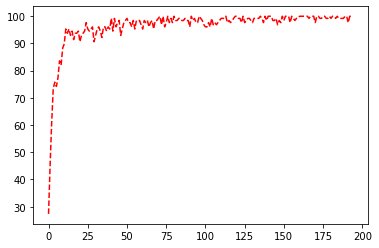

In [51]:
import matplotlib.pyplot as plt
x1 = range(len(train_acc))

l1=plt.plot(x1,train_acc,'r--',label='train')


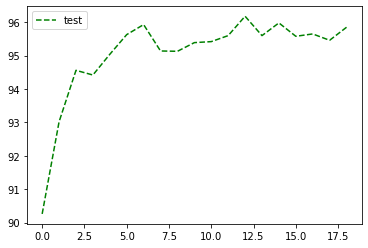

In [52]:
x2 = range(len(test_acc))
l2=plt.plot(x2,test_acc,'g--',label='test')
#plt.ylim(ymin=0.5, ymax=1.01)
plt.legend([ "test"])

plt.show()